# Challenge 2: Exploring Countries Seasonal Farming Cycles

## Overview

This notebook contains an analysis between farmer questions and the seasonal farming calender per country. By correlating question volume with ERA5 weather data, and performing NLP keyword analysis, I map distinct key words for each country.

In [1]:
import os 
import re
import duckdb
import nltk
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from collections import Counter

In [2]:
# Importing and setting path files to already translated parquet files and era5 country data.
current_directory = Path(os.getcwd())

root_directory = current_directory.joinpath('../..')

original_parquet_path = root_directory.joinpath('data/b0cd514b-b9cc-4972-a0c2-c91726e6d825.parquet')

# split data file paths

eng_parquet_path = root_directory.joinpath('data/eng.parquet')

# already sampled to obtain 0.5 percent of data of each language
swa_parquet_path = root_directory.joinpath('data/swa_translated_sample.parquet')
lug_parquet_path = root_directory.joinpath('data/lug_translated_sample.parquet')
nyn_parquet_path = root_directory.joinpath('data/nyn_translated_sample.parquet')

# split era5 data with tasmax, tasmin and prcp information for each country
kenya_era5_path = root_directory.joinpath('data/era5_kenya.xlsx')
tanzania_era5_path = root_directory.joinpath('data/era5_tanzania.xlsx')
uganda_era5_path = root_directory.joinpath('data/era5_uganda.xlsx')

path_list = [swa_parquet_path, lug_parquet_path, nyn_parquet_path]

era5_map = {
    'KE': kenya_era5_path, 
    'TZ': tanzania_era5_path, 
    'UG': uganda_era5_path}

In [3]:
# Utilizing all of the split English file as Group 1 and the split 0.5 percent of data as Group 2
conn = duckdb.connect()

kenya_query = f"""
    SELECT question_id, question_content AS eng_content, question_user_country_code, question_sent, question_topic,
    FROM read_parquet('{eng_parquet_path}')
    WHERE question_user_country_code = 'ke';
"""

ug_query =  f"""
    SELECT question_id, question_content AS eng_content, question_user_country_code, question_sent, question_topic,
    FROM read_parquet('{eng_parquet_path}')
    WHERE question_user_country_code = 'ug';
"""
# Group 1 only contains Kenya and Uganda as the English data file only has 12 rows for Tanzania.
og_ke_eng_df = conn.execute(kenya_query).fetchdf()
og_ke_eng_df['src_lang'] = 'English'

og_ug_eng_df = conn.execute(ug_query).fetchdf()
og_ug_eng_df['src_lang'] = 'English'

# Group 2 contains translated files for the translated languages which contains enough data for all three countries.
data_frames = []
for paths in path_list: 
    df_transl = pd.read_parquet(paths)

    conn.register('translated_sample', df_transl)
    
    df = conn.execute(f"""
        SELECT 
            translated_sample.question_id,
            translated_sample.question_content,
            translated_sample.translated_en AS eng_content,
            translated_sample.src_lang,
            original_sample.question_user_country_code,
            original_sample.question_sent,
            original_sample.question_topic,
        FROM translated_sample
        LEFT JOIN read_parquet('{original_parquet_path}') AS original_sample 
        ON translated_sample.question_id = original_sample.question_id     
    """).fetchdf()
    
    data_frames.append(df)
    
conn.close()

translated_dfs = pd.concat(data_frames, ignore_index = True)

dfs_to_combine = [og_ke_eng_df, og_ug_eng_df, translated_dfs]

# Combining into one dataframe, src_lang = English represents group1 and src_lang != English represents group 2.
all_dfs = pd.concat(dfs_to_combine, ignore_index=True)

# Removing duplicates and setting date to datetime
all_dfs.drop_duplicates(subset=['question_id'], keep='first', inplace=True)
all_dfs.drop_duplicates(subset=['eng_content', 'question_sent'], keep='first', inplace=True)

all_dfs['question_sent'] = pd.to_datetime(all_dfs['question_sent'],  utc=True, format='ISO8601', errors='coerce')
all_dfs['month_num'] = all_dfs['question_sent'].dt.month

before_len = len(all_dfs)
all_dfs.dropna(subset=['question_sent'], inplace=True)
after_len = len(all_dfs)

print(f"Dropped {before_len - after_len} where date is NaT")
    
all_dfs.head(5)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Dropped 2 where date is NaT


,question_id,eng_content,question_user_country_code,question_sent,question_topic,src_lang,question_content,month_num
0,37283088,"Q: Between Pig farming and poultry farming,whi...",ke,2020-02-09 15:52:02.562774+00:00,pig,English,NaN,2.0
1,38346880,Q pregnant cow is supost to be give what kind...,ke,2020-03-06 11:18:28.946785+00:00,cattle,English,NaN,3.0
2,39360036,Q if the queen dies in the beehive what wil...,ke,2020-03-31 12:24:04.320909+00:00,bee,English,NaN,3.0
3,39867925,"Q, I'm in need of a dairy goat, anyone or con...",ke,2020-04-07 11:55:10.334660+00:00,goat,English,NaN,4.0
4,43008197,Qwhich maize is good to plant in a black soil,ke,2020-06-04 18:07:45.928548+00:00,plant,English,NaN,6.0


In [4]:
# Categorizing via NLTK 
custom_stops = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

hallucination_words = ['attorney', 'general', 'prime', 'minister', 'parliament', 'football', 
    'premier', 'league', 'musician', 'contract', 'sinnin', 'guyaya', 
    'qipssss', 'aiiiiii']
custom_stops.update(hallucination_words)

updated_stops = [
    'want', 'ask', 'asks', 'help', 'question', 'fine', 'good', 'best', 
    'know', 'person', 'tell', 'thank', 'thanks', 'hello', 'dear', 'sir',
    'please', 'like', 'need',  'man', 'mother', 'brother', 'sister', 'body', 
    'piece', 'single', 'game', 'clean', 'filled', 'helping', 'search', 'pain', 
    'called', 'dont', 'start', 'day', 'world', 'thing', 'use', 'qwhat', 'qhow', 'qwhich'
]
custom_stops.update(updated_stops)

noise_words = [
    'virus', 'army', 'ministry', 'human', 'primary', 'lecturer', 'lake', 
    'hundred', 'end', 'going', 'back', 'way', 'would', 'could', 'thing', 
    'much', 'many', 'one', 'two', 'get', 'got', 'make', 'see', 'take', 'long', 'type'
]
custom_stops.update(noise_words)

word_map = {
    'corn': 'maize',
    'chick': 'chicken',
    'hen': 'chicken',
    'cows': 'cow'
}

def clean_text(text): 
    text = str(text).lower()
    # replacing any punctuation
    text = re.sub(r'(.)\1{2,}', '', text)
    # split text and check select words not in custom_stops
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()

    clean_tokens = []
    for t in tokens:
        t = word_map.get(t, t)
        if t in custom_stops:
            continue
    
        if len(t) < 3 or len(t) > 12:
            continue
            
        lemma = lemmatizer.lemmatize(t)
        if lemma not in custom_stops:
            clean_tokens.append(lemma)

    return " ".join(clean_tokens)
    
all_dfs['clean_text'] = all_dfs['eng_content'].apply(clean_text)
all_dfs

,question_id,eng_content,question_user_country_code,question_sent,question_topic,src_lang,question_content,month_num,clean_text
0,37283088,"Q: Between Pig farming and poultry farming,whi...",ke,2020-02-09 15:52:02.562774+00:00,pig,English,NaN,2.0,pig farming poultry farmingwhich assist come p...
1,38346880,Q pregnant cow is supost to be give what kind...,ke,2020-03-06 11:18:28.946785+00:00,cattle,English,NaN,3.0,pregnant cow supost give kind salt
2,39360036,Q if the queen dies in the beehive what wil...,ke,2020-03-31 12:24:04.320909+00:00,bee,English,NaN,3.0,queendies beehive happen whole bee beehive
3,39867925,"Q, I'm in need of a dairy goat, anyone or con...",ke,2020-04-07 11:55:10.334660+00:00,goat,English,NaN,4.0,dairy goat anyone connection kericho
4,43008197,Qwhich maize is good to plant in a black soil,ke,2020-06-04 18:07:45.928548+00:00,plant,English,NaN,6.0,maize plant black soil
...,...,...,...,...,...,...,...,...,...
11781486,58187533,The court has stated that he is a suspect.,ug,2021-08-09 19:01:06.282525+00:00,cattle,nyn,E ente yereire kashanku neyine buboneroki.,8.0,court stated suspect
11781493,58190439,When did the two best farmers get their shares?,ug,2021-08-10 04:14:40.897668+00:00,bean,nyn,"E mureire muta abahingi bangyenzi bangye, omud...",8.0,farmer share
11781501,58190889,My grandchildren are my favorite heroes.,ug,2021-08-10 04:40:22.797761+00:00,chicken,nyn,Enkoko zangye ni zirukana zepamira nkazitambir...,8.0,favorite hero
11781503,58198726,How many kilos of maize are in the market?,ug,2021-08-10 10:04:17.017477+00:00,None,nyn,E hika ina nizibyarwa kilo zingahi? Anatoli se...,8.0,kilo maize market


In [5]:
# Defining seasonality cycles to each country

def set_regional_farming_season(row):
    country = row['question_user_country_code']
    month = row['month_num']
    
    if country == 'ke':
        if month in [3, 4, 5]:
            return 'Long Rains: Planting Season 1 (March - May)'
        elif month in [6, 7, 8]:
            return 'Harvest 1 (June-Aug)' 
        elif month in [9]:
            return 'Transition (Sep)'
        elif month in [10, 11, 12]:
            return 'Short Rains: Planting Season 2 (Oct-Dec)'
        elif month in [1, 2]:
            return 'Harvest 2 (Jan-Feb)'

    if country == 'tz':
        if month in [3, 4, 5]:
            return 'Masika Rains: Planting Season 1 (March-May)'
        elif month in [6, 7, 8]:
             return 'Harvest (June-Aug)'
        elif month in [9]:
            return 'Transition (Sep)'
        elif month in [10, 11, 12]:
             return 'Vuli Rains: Planting Season 2  (Oct - Nov)' 
        elif month in [1, 2]:
             return 'Early Planting (Jan-Feb)'
            
    if country == 'ug':
        if month in [3, 4, 5]:
            return 'First Rains: Planting Season 1 (March-May)'
        elif month in [6, 7, 8]:
             return 'Harvest 1 (June-Aug)'
        elif month in [9, 10, 11]:
             return 'Second Rains: Planting Season 2 (Sept - Nov)'
        elif month in [12, 1, 2]:
            return 'Harvest 2 (Dec-Feb)'

all_dfs['month_num'] = all_dfs['month_num'].astype(int)
all_dfs['farming_season'] = all_dfs.apply(set_regional_farming_season, axis=1)
all_dfs

,question_id,eng_content,question_user_country_code,question_sent,question_topic,src_lang,question_content,month_num,clean_text,farming_season
0,37283088,"Q: Between Pig farming and poultry farming,whi...",ke,2020-02-09 15:52:02.562774+00:00,pig,English,NaN,2,pig farming poultry farmingwhich assist come p...,Harvest 2 (Jan-Feb)
1,38346880,Q pregnant cow is supost to be give what kind...,ke,2020-03-06 11:18:28.946785+00:00,cattle,English,NaN,3,pregnant cow supost give kind salt,Long Rains: Planting Season 1 (March - May)
2,39360036,Q if the queen dies in the beehive what wil...,ke,2020-03-31 12:24:04.320909+00:00,bee,English,NaN,3,queendies beehive happen whole bee beehive,Long Rains: Planting Season 1 (March - May)
3,39867925,"Q, I'm in need of a dairy goat, anyone or con...",ke,2020-04-07 11:55:10.334660+00:00,goat,English,NaN,4,dairy goat anyone connection kericho,Long Rains: Planting Season 1 (March - May)
4,43008197,Qwhich maize is good to plant in a black soil,ke,2020-06-04 18:07:45.928548+00:00,plant,English,NaN,6,maize plant black soil,Harvest 1 (June-Aug)
...,...,...,...,...,...,...,...,...,...,...
11781486,58187533,The court has stated that he is a suspect.,ug,2021-08-09 19:01:06.282525+00:00,cattle,nyn,E ente yereire kashanku neyine buboneroki.,8,court stated suspect,Harvest 1 (June-Aug)
11781493,58190439,When did the two best farmers get their shares?,ug,2021-08-10 04:14:40.897668+00:00,bean,nyn,"E mureire muta abahingi bangyenzi bangye, omud...",8,farmer share,Harvest 1 (June-Aug)
11781501,58190889,My grandchildren are my favorite heroes.,ug,2021-08-10 04:40:22.797761+00:00,chicken,nyn,Enkoko zangye ni zirukana zepamira nkazitambir...,8,favorite hero,Harvest 1 (June-Aug)
11781503,58198726,How many kilos of maize are in the market?,ug,2021-08-10 10:04:17.017477+00:00,None,nyn,E hika ina nizibyarwa kilo zingahi? Anatoli se...,8,kilo maize market,Harvest 1 (June-Aug)


In [6]:
# Reading ERA5 files and combining into one dataframe.
def process_excel_file(path, country_code):
    xlsx_file = pd.ExcelFile(path)

    def load_sheet(sheet_number, value_name): 
        df = pd.read_excel(xlsx_file, sheet_name=sheet_number)
        df_melt = pd.melt(
            df, 
            id_vars = ['code', 'name'],
            var_name = 'date',
            value_name = value_name
        )

        return df_melt

    df_prcp = load_sheet(0, 'prcp')
    df_tasmax = load_sheet(1, 'tasmax')
    df_tasmin = load_sheet(2, 'tasmin')

    df_combined = pd.merge(df_prcp, df_tasmax, on=['code', 'name', 'date'])
    df_combined = pd.merge(df_combined, df_tasmin, on=['code', 'name', 'date'])

    df_combined['code'] = country_code
    df_combined['date'] = pd.to_datetime(df_combined['date'])

    return df_combined

weather_dfs = []

for path_country, path in era5_map.items(): 
    df_country = process_excel_file(path, path_country)
    weather_dfs.append(df_country)

weather_combined_df = pd.concat(weather_dfs, ignore_index=True)

df_weather_final = weather_combined_df.groupby(['code', 'date']).agg({
    'prcp': 'mean',
    'tasmax': 'mean',
    'tasmin': 'mean'
}).reset_index()

df_weather_final['month_key'] = df_weather_final['date'].dt.to_period('M')

## Visualizations 

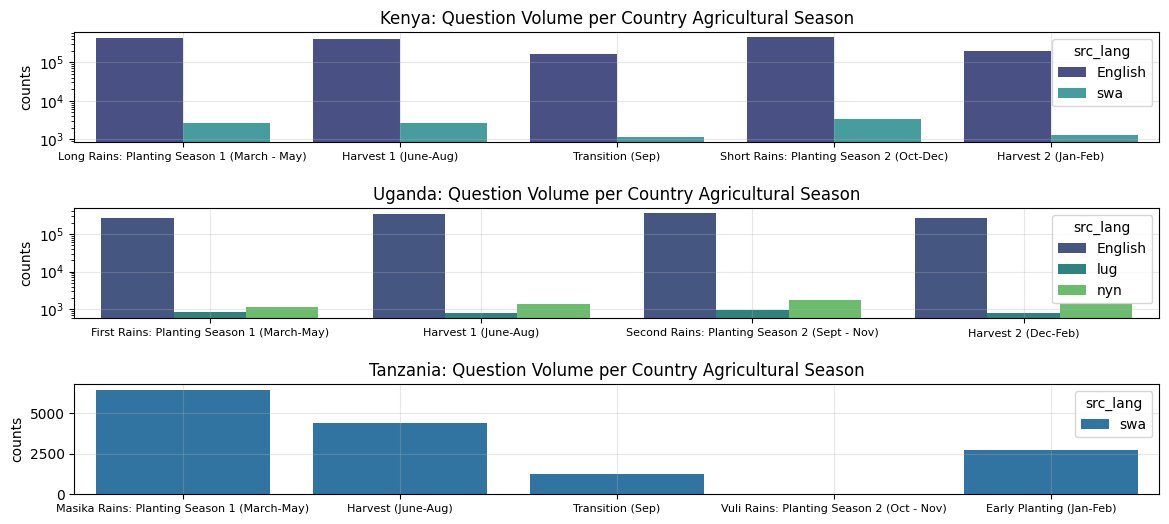

In [7]:
# Visualizing counts by Country's Farming Season
grouped_df = all_dfs.groupby(['question_user_country_code', 'src_lang', 'farming_season']).size().reset_index()
grouped_df.rename(columns={0:'counts'}, inplace=True)

ke_order = ['Long Rains: Planting Season 1 (March - May)', 'Harvest 1 (June-Aug)', 'Transition (Sep)', 'Short Rains: Planting Season 2 (Oct-Dec)', 'Harvest 2 (Jan-Feb)']
ug_order = ['First Rains: Planting Season 1 (March-May)', 'Harvest 1 (June-Aug)', 'Second Rains: Planting Season 2 (Sept - Nov)', 'Harvest 2 (Dec-Feb)']
tz_order = ['Masika Rains: Planting Season 1 (March-May)', 'Harvest (June-Aug)', 'Transition (Sep)', 'Vuli Rains: Planting Season 2 (Oct - Nov)', 'Early Planting (Jan-Feb)']

# Question count by Kenya agricultural season (All of the Split English Group and the 0.5 Sampled Translated Group)
ke_combined_group = grouped_df[grouped_df['question_user_country_code'] == 'ke']

# Question count by Uganda agricultural season (All of the Split English Group and the 0.5 Sampled Translated Group)
ug_combined_group = grouped_df[grouped_df['question_user_country_code'] == 'ug']

# Question count by Tanzania agricultural season (0.5 Sampled Translated Group)
tz_translated_group =  grouped_df[grouped_df['question_user_country_code'] == 'tz']

fig, axs = plt.subplots(3, 1, sharex = False, figsize=(14, 6))

axs[0].set_title('Kenya: Question Volume per Country Agricultural Season')
sns.barplot(data=ke_combined_group, x='farming_season', y='counts', hue='src_lang', order=ke_order, palette='mako', ax=axs[0])
axs[0].tick_params(axis='x', labelsize=8)
axs[0].set_xlabel('')
axs[0].set_yscale('log')
axs[0].grid(True, alpha=0.3)

plt.subplots_adjust(hspace=0.6)

axs[1].set_title('Uganda: Question Volume per Country Agricultural Season')
sns.barplot(data=ug_combined_group, x='farming_season', y='counts', hue='src_lang', order=ug_order, palette='viridis', ax=axs[1])
axs[1].tick_params(axis='x', labelsize=8)
axs[1].set_xlabel('')
axs[1].set_yscale('log')
axs[1].grid(True, alpha=0.3)

plt.subplots_adjust(hspace=0.6)

axs[2].set_title('Tanzania: Question Volume per Country Agricultural Season')
sns.barplot(data=tz_translated_group, x='farming_season', y='counts', hue='src_lang', order=tz_order, ax=axs[2])
axs[2].tick_params(axis='x', labelsize=8)
axs[2].set_xlabel('')
axs[2].grid(True, alpha=0.3)

plt.show()

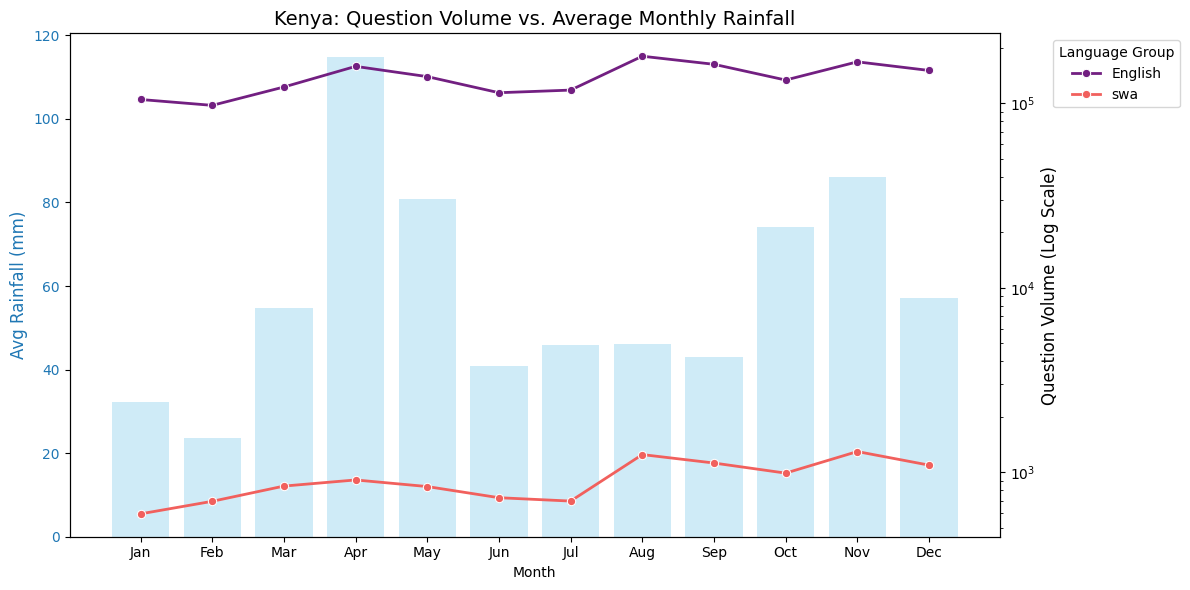

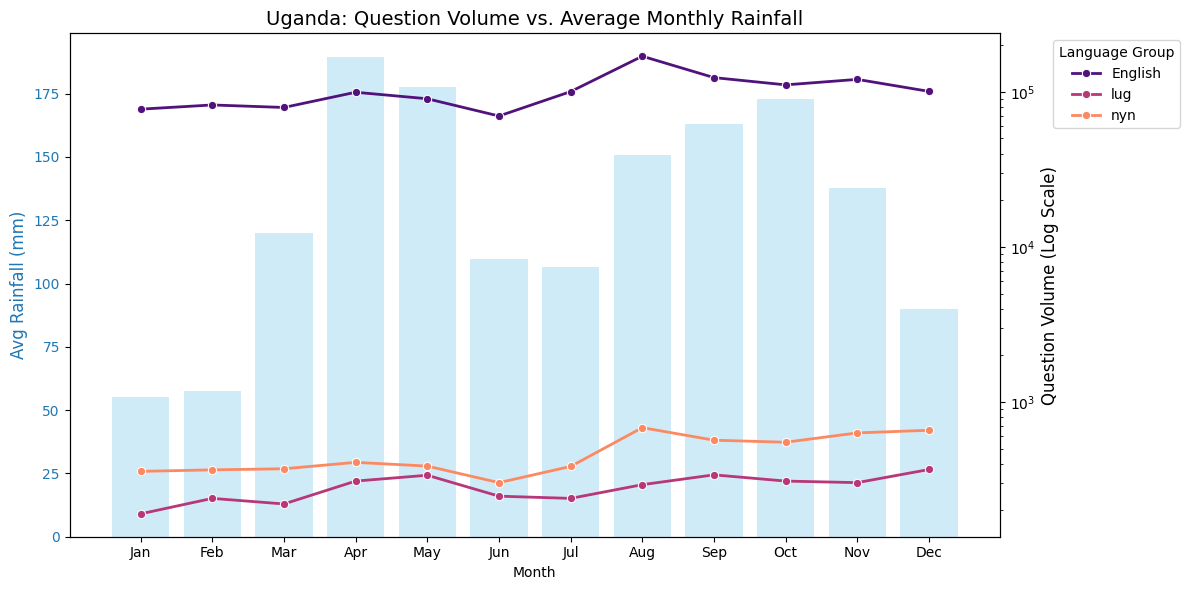

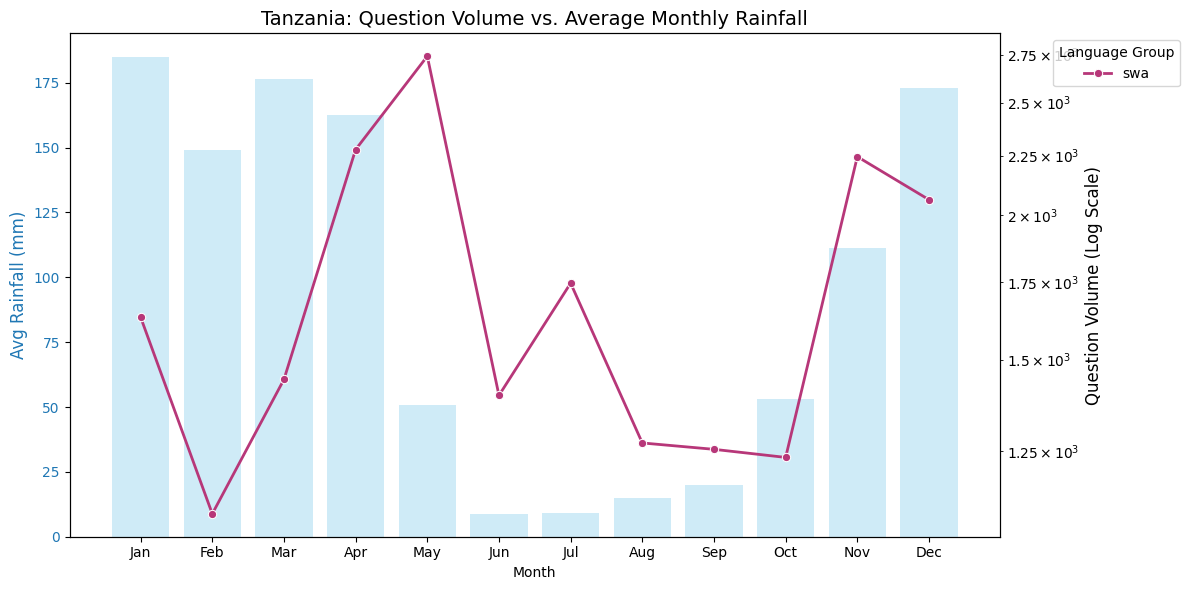

In [8]:
# Visualizing Question Volume per Country Average Monthly Rainfall
monthly_trend = all_dfs.groupby(['question_user_country_code', 'src_lang', 'month_num']).size().reset_index(name='counts')

filtered_era5 = df_weather_final[(df_weather_final['date'].dt.year >= 2017) &
    (df_weather_final['date'].dt.year <= 2022)].copy()
filtered_era5['month_num'] = filtered_era5['date'].dt.month

era5_seasonal_avg = filtered_era5.groupby(['code', 'month_num'])['prcp'].mean().reset_index()
era5_seasonal_avg['code'] = era5_seasonal_avg['code'].str.lower()

def plot_weather_overlay(country_code, country_name):
    question_data = monthly_trend[monthly_trend['question_user_country_code'] == country_code]
    weather_data = era5_seasonal_avg[era5_seasonal_avg['code'] == country_code]
    
    fig, ax1 = plt.subplots(figsize=(12, 6))

    plt.title(f'{country_name}: Question Volume vs. Average Monthly Rainfall', fontsize=14)
    
    ax1.bar(weather_data['month_num'], weather_data['prcp'], color='skyblue', alpha=0.4)
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Avg Rainfall (mm)', color='tab:blue', fontsize=12)
    
    ax2 = ax1.twinx()
    sns.lineplot(
        data=question_data, 
        x='month_num', 
        y='counts', 
        hue='src_lang',
        palette='magma', 
        marker='o', 
        linewidth=2,
        ax=ax2 
    )
    
    ax2.set_ylabel('Question Volume (Log Scale)', color='black', fontsize=12)
    ax2.set_yscale('log')
    ax2.legend(title='Language Group', loc='upper left', bbox_to_anchor=(1.05, 1))
    
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    
    plt.tight_layout()
    plt.savefig(f'{country_name}_qprcp.png')
    plt.show()

plot_weather_overlay('ke', 'Kenya')
plot_weather_overlay('ug', 'Uganda')
plot_weather_overlay('tz', 'Tanzania')

In [9]:
# Defining functions to obtain seasonal word frequencies and identifying most frequent words 
def seasonal_freq(df, group_col):
    freq_dict = {}
    seasons =  df[group_col].unique()

    for season in seasons: 
        df_season = df[df[group_col] == season]
        all_text = " ".join(df_season['clean_text'].astype(str).tolist())

        tokens = all_text.split()
        freq_dict[season] = Counter(tokens)

    return freq_dict

def get_top_words(freq_dict, df, group_col, stop_words, top_n=20):
    top_words_dict = {}

    for season_value, word_count in freq_dict.items():
        total_questions = len(df[df[group_col] == season_value])
        
        filtered = {
            word: count for word, count in word_count.items()
            if word not in stop_words and len(word) > 2
        }

        sorted_words = sorted(filtered.items(), key=lambda x: x[1], reverse=True)[:top_n]
        
        top_words_dict[season_value] = []
        for word, count in sorted_words:
            per_1k = (count / total_questions) * 1000 if total_questions > 0 else 0
            
            top_words_dict[season_value].append({
                'word': word,
                'count': count,
                'per_1k': per_1k
            })
        
    return top_words_dict

In [10]:
# Obtaining the top 20 words for each season per Country group.
segments = [
    {'country': 'ke', 'english_only': True, 'label': 'Kenya (English)'},
    {'country': 'ke', 'english_only': False, 'label': 'Kenya (Translated)'},
    {'country': 'ug', 'english_only': True, 'label': 'Uganda (English)'},
    {'country': 'ug', 'english_only': False, 'label': 'Uganda (Translated)'},
    {'country': 'tz', 'english_only': False, 'label': 'Tanzania (Translated)'}
]

heatmap_data_list = []
for segment in segments: 
    print(f"Analyzing {segment['label']}")
    if segment['english_only']:
        subset_df = all_dfs[
            (all_dfs['question_user_country_code'] == segment['country']) & 
            (all_dfs['src_lang'] == 'English')
        ]
    else:
        subset_df = all_dfs[
            (all_dfs['question_user_country_code'] == segment['country']) & 
            (all_dfs['src_lang'] != 'English')
        ]

    freq_dict = seasonal_freq(subset_df, 'farming_season')

    top_words = get_top_words(freq_dict, subset_df, 'farming_season', custom_stops, top_n=20)

    for season, words_list in top_words.items():
        print(f"\n  Season: {season}")
        for word_data in words_list:
            print(f"{word_data['word']}: {word_data['per_1k']:.1f}")
            
            heatmap_data_list.append({
                'Group': segment['label'],
                'Season': season,
                'Word': word_data['word'],
                'Frequency_Per_1k': word_data['per_1k']
            })
            
df_heatmap = pd.DataFrame(heatmap_data_list)

Analyzing Kenya (English)

  Season: Harvest 2 (Jan-Feb)
maize: 89.8
cow: 86.3
plant: 77.0
chicken: 66.7
seed: 40.7
planting: 38.6
tomato: 36.3
chick: 36.1
farm: 33.4
give: 32.0
crop: 30.1
farmer: 26.8
poultry: 26.4
county: 26.0
milk: 25.5
bean: 25.4
feed: 25.3
egg: 25.0
control: 24.7
farming: 24.5

  Season: Long Rains: Planting Season 1 (March - May)
maize: 99.3
plant: 84.1
cow: 80.4
chicken: 59.2
planting: 37.8
seed: 36.9
tomato: 34.5
farm: 33.9
bean: 33.3
control: 30.6
potato: 29.8
give: 29.1
crop: 28.7
chick: 27.5
farmer: 24.2
feed: 23.4
fertilizer: 23.0
milk: 22.6
disease: 22.4
used: 22.0

  Season: Harvest 1 (June-Aug)
cow: 87.3
plant: 79.4
maize: 66.7
tomato: 61.1
chicken: 58.9
farm: 33.3
seed: 33.0
bean: 32.5
give: 31.4
planting: 31.2
control: 30.3
chick: 30.3
potato: 28.4
crop: 26.2
farmer: 25.7
feed: 25.5
month: 24.3
cabbage: 23.6
cause: 23.4
problem: 23.4

  Season: Transition (Sep)
maize: 102.7
cow: 90.7
plant: 80.1
chicken: 64.6
tomato: 54.7
bean: 35.2
seed: 34.9
chick: 3

In [11]:
# Function to create heatmap
generic_excludes = [
    'give', 'get', 'many', 'one', 'type', 'month', 'year', 
    'time', 'help', 'know', 'want', 'food','question', 'answer', 
    'good', 'need', 'start', 'cause', 'find', 'small', 'city', 'think', 'come'
]

def create_heatmap(ax, df, group_col, title):
    subset = df[df['Group'] == group_col]

    word_peaks = subset.groupby('Word')['Frequency_Per_1k'].max().sort_values(ascending=False)
    clean_peaks = [w for w in word_peaks.index if w not in generic_excludes]
    local_top_10 = clean_peaks[:10]
    subset = subset[subset['Word'].isin(local_top_10)]
    
    pivoted_subset = subset.pivot(index='Word', columns='Season', values='Frequency_Per_1k')
    pivoted_subset = pivoted_subset.reindex(local_top_10)
    pivoted_subset = pivoted_subset.fillna(0)

    sns.heatmap(pivoted_subset, annot=True, fmt='.0f', cmap='RdYlGn_r', 
                cbar_kws={'label': 'Freq per 1K'},
                linewidths=0.5, ax=ax, annot_kws={'fontsize': 10})
    
    ax.set_ylabel('Word', fontsize=10)
    ax.set_xlabel('')
    ax.set_title(title, fontsize=13, fontweight='bold', pad=10, loc='left')
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=7.7)

    return ax

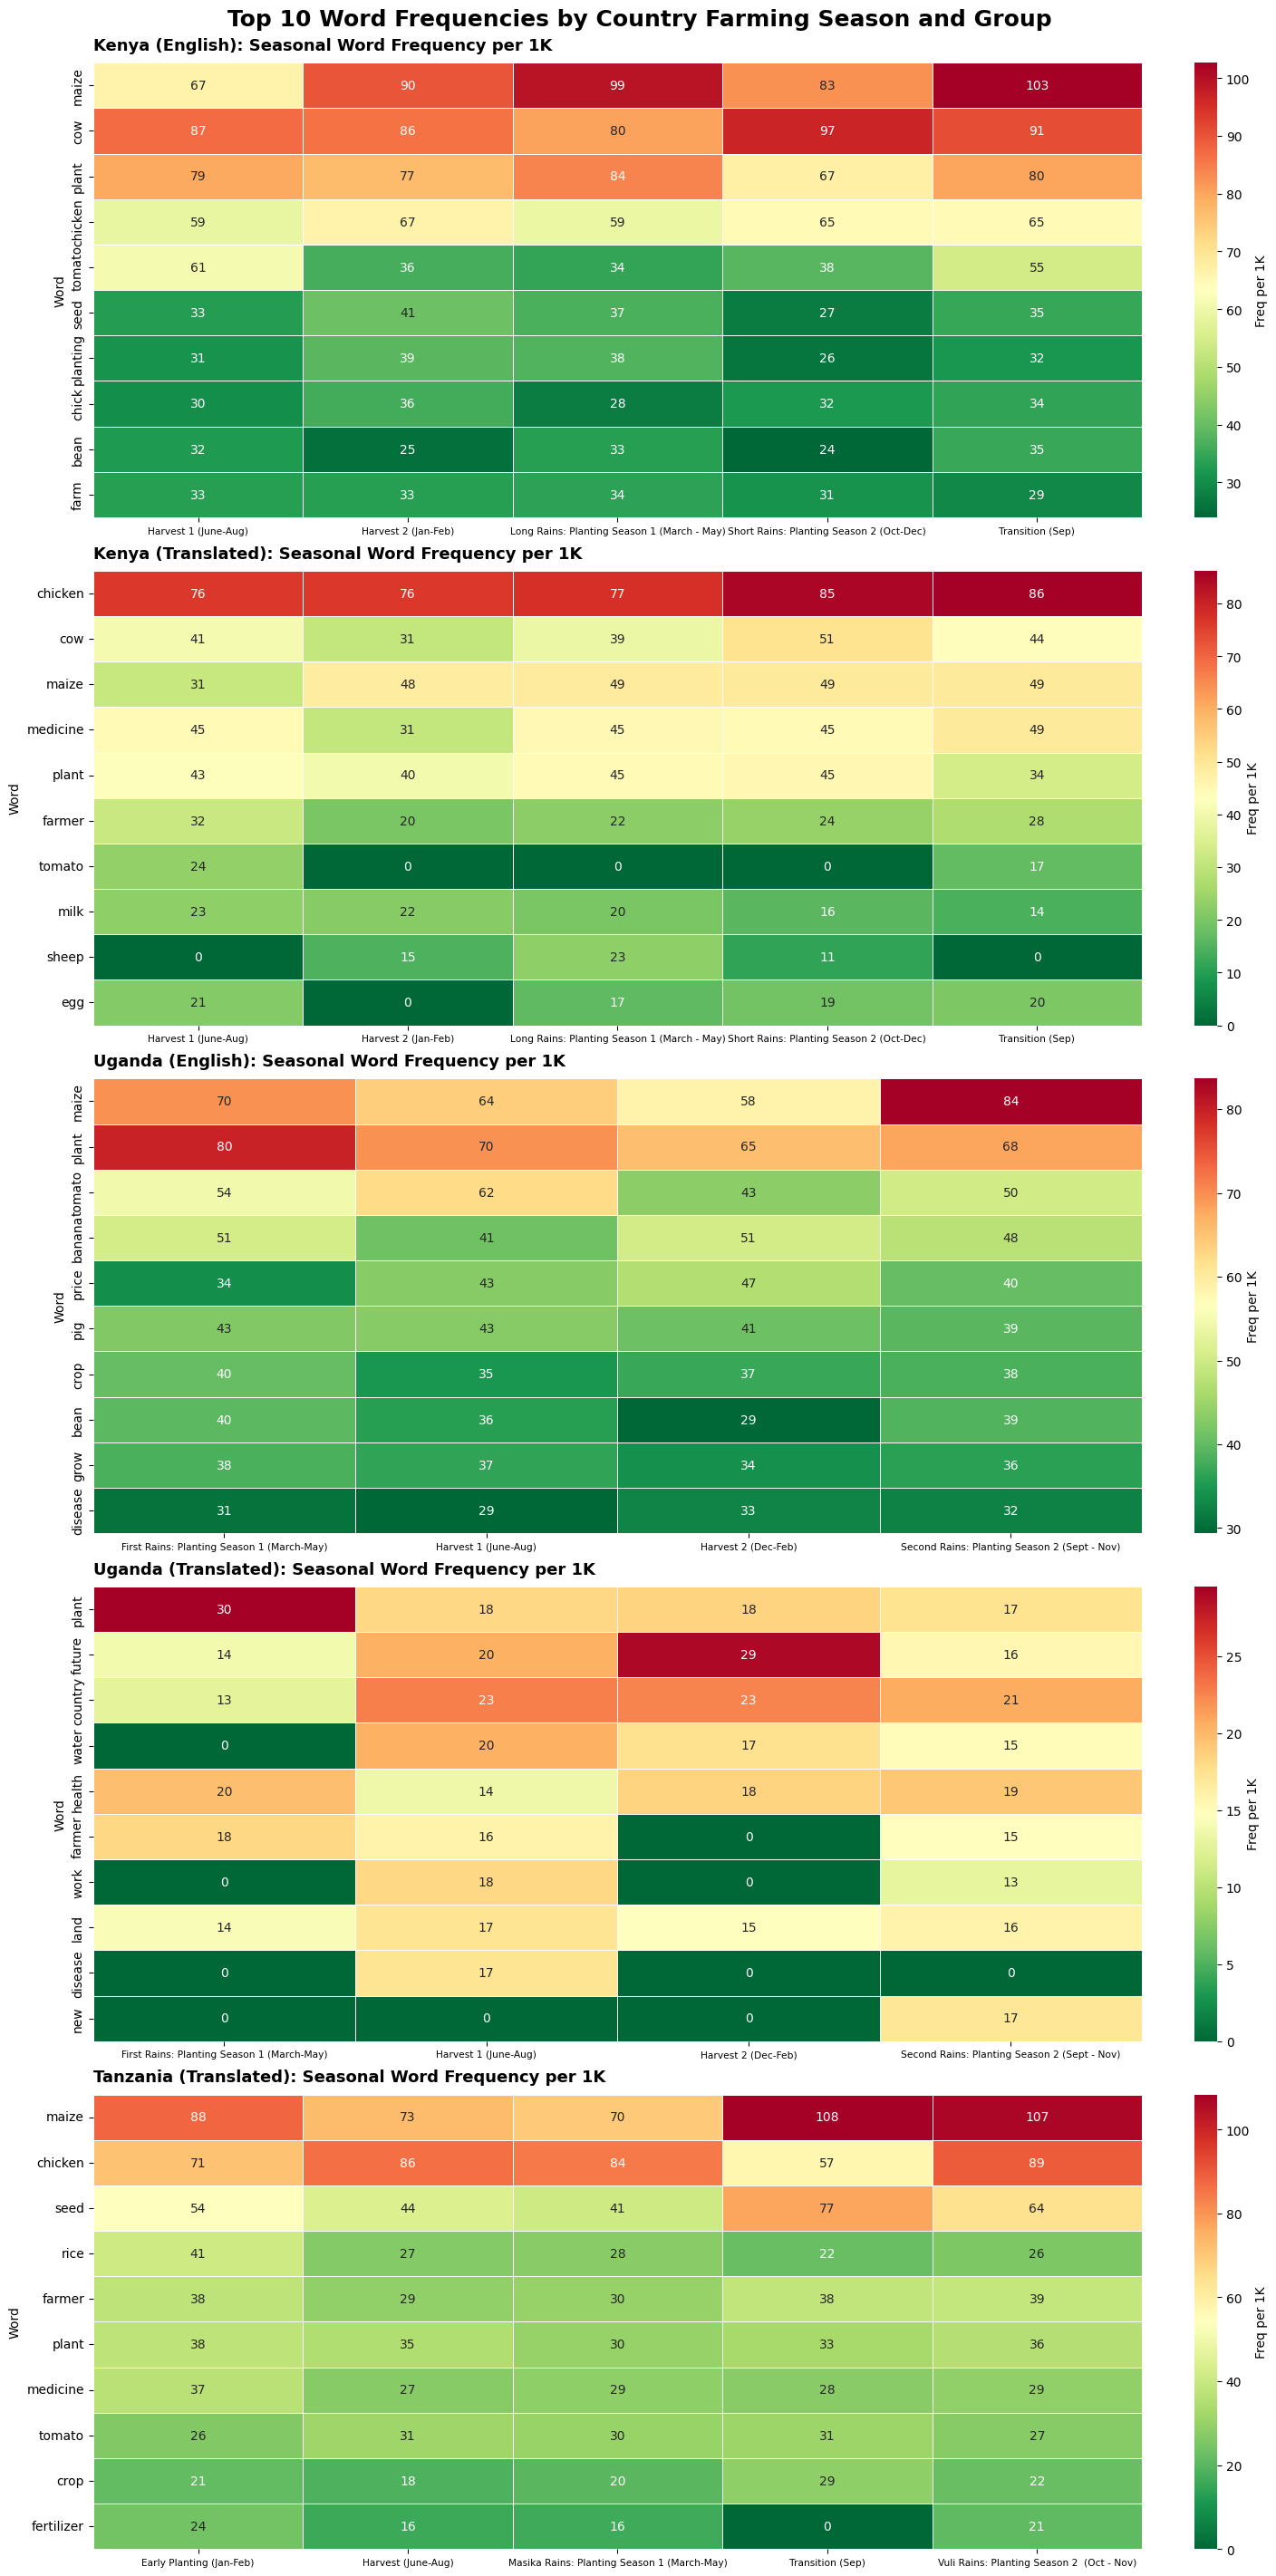

In [12]:
# Visualizing top 10 words for each Country Group's Farming Cycle as a heatmap.

ke_seasons = ['1. Long Rains (Mar-May)', '2. Harvest 1 (Jun-Aug)', '3. Transition (Sep)', '4. Short Rains (Oct-Dec)', '5. Harvest 2 (Jan-Feb)']
ug_seasons = ['1. First Rains (Mar-May)', '2. Harvest A (Jun-Aug)', '3. Second Rains (Sep-Nov)', '4. Harvest B (Dec-Feb)']
tz_seasons = ['1. Masika Rains (Mar-May)', '2. Harvest (June-Aug)', '3. Transition (Sep)', '4. Vuli Rains (Oct - Nov)', '5. Early Planting (Jan-Feb)']

groups_to_plot = [
    {'name': 'Kenya (English)','seasons': ke_seasons},
    {'name': 'Kenya (Translated)','seasons': ke_seasons},
    {'name': 'Uganda (English)','seasons': ug_seasons},
    {'name': 'Uganda (Translated)','seasons': ug_seasons},
    {'name': 'Tanzania (Translated)','seasons': tz_seasons}
]


fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(14, 28), constrained_layout=True)

for i, group_info in enumerate(groups_to_plot):
        create_heatmap(
            ax=axes[i],
            df=df_heatmap,
            group_col=group_info['name'], 
            title=f"{group_info['name']}: Seasonal Word Frequency per 1K"
        )

plt.suptitle('Top 10 Word Frequencies by Country Farming Season and Group', fontsize=18, fontweight='bold', y=1.01)
plt.savefig('word_frequencies_countries.png')
plt.show()